### 코인개코를 통하여, 시가총액 순으로 티커를 받아옵니다
### 이후 크립토컴페어를 통하여 2015~2023.10 까지의 일별, 종가, 거래량을 받아옵니다
### 허나, 티커 형식의 약간의 차이로 178개의 코인을 받아옴

In [1]:
#코인개코 이용 시가총액 순위 300개 불러오기
# 단 호출 시간 등이 제한이 있어서 텀 두고 하거나, 이후 작업에는 데이터프레임을 미리 만들어 놓고 할 것
import requests
import pandas as pd

# API 엔드포인트 URL
url = "https://api.coingecko.com/api/v3/coins/markets"
symbol = pd.DataFrame()
for i in range(0, 3):
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": 100,
        "page": i
    }

    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        selected_items = []
        for item in data:
            symbol1 = item["symbol"]
            name1 = item["name"]
            selected_items.append({'symbol': symbol1, 'name': name1})
        df1 = pd.DataFrame(selected_items)
        symbol = pd.concat([symbol, df1], ignore_index=True)
    else:
        print(f"에러 : {response.status_code}")
        
symbol.to_csv('symbol.csv')

In [25]:
       
#cryptocompare를 통해서 정확하게 usd(달러로) 받아오기 시가총액 상위 300개
import time
import requests
import pandas as pd
symbol = pd.read_csv('symbol.csv', encoding='CP949')
close_df = pd.DataFrame(columns=['Timestamp', 'Close'])
volume_df = pd.DataFrame(columns=['Timestamp', 'Volume'])

#j=k+1
for k in range(0,len(symbol)):    
    API_KEY = '키는지울게요' #api 키임
    coin_symbol = symbol.loc[k, 'symbol'] #이전 코인개코로 받은 symbol들, coincompare 에서 없을 수도 있음
    start_date = pd.to_datetime('2015-01-01')
    end_date = pd.to_datetime('2023-10-31')

    base_url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': coin_symbol,
        'tsym': 'USD',
        'api_key': API_KEY,
        'limit': 2000  # 한 번에 가져올 수 있는 최대 데이터 제한 값
    }

    date_range = pd.date_range(start=start_date, end=end_date, freq='1D')
    

    for i in range(0, len(date_range), params['limit']): #시작일부터 끝일까지인데 한번에 받는게 2000뿐이라서...
        if i + params['limit'] > len(date_range):
            params['limit'] = len(date_range) - i

        params['toTs'] = int(date_range[i + params['limit'] - 1].timestamp())

        response = requests.get(base_url, params=params)
        data = response.json()
        if 'Response' in data and data['Response'] == 'Success': #성공시
            if 'Data' in data:
                day_data = data['Data']['Data']
                df = pd.DataFrame(day_data, columns=['time', 'close', 'volumeto', 'marketcap'])
                df['Timestamp'] = pd.to_datetime(df['time'], unit='s')
                df = df[['Timestamp', 'close', 'volumeto']]
                df.columns = ['Timestamp', 'Close', 'Volume']
                df['Symbol'] = coin_symbol

                close_df = pd.concat([close_df, df[['Timestamp', 'Close', 'Symbol']]], ignore_index=True)
                volume_df = pd.concat([volume_df, df[['Timestamp', 'Volume', 'Symbol']]], ignore_index=True)

        # 요청 사이에 1초의 딜레이 추가
        time.sleep(1)

print("Close DataFrame:")
print(close_df)

print("\nVolume DataFrame:")
print(volume_df)

#import winsound
#symbol로 피벗해서 데이터 정리
close_df = close_df.pivot_table(index='Timestamp', columns='Symbol', values='Close').reset_index()
volume_df = volume_df.pivot_table(index='Timestamp', columns='Symbol', values='Volume').reset_index()

close_df.to_csv('close_df_cc.csv', na_rep='', index=False)
volume_df.to_csv('volume_df_cc.csv', na_rep='', index=False)

#winsound.Beep(500, 2000)

<Response [429]>

### 야후파이낸스를 통하여, S&P500의 수익률을 구하고, 이후 모든 코인들의 거래량, 종가의 수익률(변화율) 측정
### 거래량은 분석에는 사용하지 않았으나, 이후 추가할 수 도 있음

In [4]:
import warnings
import pandas as pd
import numpy as np
close_df = pd.read_csv('close_df_cc.csv', index_col=0)
volume_df = pd.read_csv('volume_df_cc.csv', index_col=0)
# PerformanceWarning 경고를 끄기
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

close_df[volume_df == 0] = np.nan #거래량이 없는 경우 가격도 없음, 다운받은 종가 데이터는 거래가 없어도, 정지여도 0으로 종가가 찍힘
last_close = close_df.shift(1)
diff_close = np.log(close_df/last_close)
last_volume = volume_df.shift(1)
diff_volume = np.log(volume_df/last_volume)
diff_close = diff_close[1:]
diff_volume = diff_volume[1:]
diff_close.index = pd.to_datetime(diff_close.index).date
diff_volume.index = pd.to_datetime(diff_volume.index).date

num_coin = len(diff_close.columns)

import yfinance as yf
start_date = '2014-12-31'
end_date = '2023-10-31'
sp500 = yf.download('SPY', start=start_date, end=end_date)
sp500 = pd.DataFrame(sp500['Adj Close'])

sp500.columns = ['SP500']
last_sp500 = sp500.shift(1)
diff_sp500 = np.log(sp500/last_sp500)
diff_sp500.index = diff_sp500.index.date
diff_sp500 = diff_sp500[1:]

df = pd.merge(diff_close, diff_sp500, left_index=True, right_index=True, how = 'outer')
df['SP500'] = df['SP500'].fillna(0) #SP500과 같은 경우는, 주식시장이기에, 연중무휴인 코인시장과 다름
# 이경우 SP500의 가격이 아닌, 수익률의 변화가 없었음을 표현하고자함

beta=pd.DataFrame()
alpha=pd.DataFrame()
pvalue=pd.DataFrame()
corr=pd.DataFrame()
window_size = 251 # 250일치 이전임, 이후 변경될 수도?

from statsmodels.regression.rolling import RollingOLS
from scipy.stats import t
for i in range(0, num_coin):
    df['target'] = df[df.columns[i]]
    roll_reg2 = RollingOLS.from_formula('SP500 ~ target', window=251,min_nobs=251, data=df,missing='drop') #target 하고 SP500하고 250일치 reg만 봄
    model3 = roll_reg2.fit()
    para2 = model3.params
    beta[df.columns[i]]=para2['target']
    alpha[df.columns[i]]=para2['Intercept']
    corr[df.columns[i]] = df[df.columns[i]].rolling(window=window_size).corr(df['SP500']) #dropna 없어야 기존 형식 유지됨
    #rolling은 p-value 제공 안함, 직접 구해보면
    tvalues = model3.tvalues['target']
    df_resid = model3.df_resid
    pvals = t.sf(abs(tvalues), df_resid) * 2  #양측으로
    pvalue[df.columns[i]] = pvals


alpha.to_csv('alpha.csv', index=True)
beta.to_csv('beta.csv', index=True)
pvalue.to_csv('pvalue.csv', index=True)
corr.to_csv('corr.csv', index=True)
df.to_csv('df.csv', index=True)

C:\Users\이세준\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


[*********************100%%**********************]  1 of 1 completed


### SP500과의 reg 통하여, alpha, beta, beta의 p-value, correlation 등을 추출하였고
### 이 값들을 통하여, 주식시장과의 연관이 있어보이는 코인들을 추출해 보고자 한다.

### EVENT : 절댓값 10% 이상의 주가변화
### 상한가 근처 의미 52_WK_HI, 하한가 근처 의미 52_WK_LO 등을 계산하여 추출하고자함
### 52_WK_HI = 사건 전날가격/250일 최고가 -> 1에 가까울 수록 사건일 전 가격이 상한가에 가까움
### 52_WK_LO = 250일 최저가/사건 전날 가격 -> 1에 가까울 수록 사건일 전 가격이 하한가에 가까움


In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('df.csv', index_col=0)
beta = pd.read_csv('beta.csv', index_col=0)
alpha = pd.read_csv('alpha.csv', index_col=0)
pvalue = pd.read_csv('pvalue.csv', index_col=0)
corr = pd.read_csv('corr.csv', index_col=0)
close_df = pd.read_csv('close_df_cc.csv', index_col=0)
event=pd.DataFrame(columns=['date','name', 'df', 'beta', 'pvalue' ,'corr'])
num_coin = len(close_df.columns)
count = 0
for n in range(0, num_coin):
    for m in range(0, len(df)):
        if abs(df.iloc[m, n]) >= 0.1 and not(pd.isna(corr.iloc[m,n])): #corr 가 없는, 즉 이전 250일치가 존재하지 않으면 제욓마
            event.loc[count, 'date'] = df.index[m]
            event.loc[count, 'name'] = df.columns[n]
            event.loc[count, '52_WK_HI'] = close_df.iloc[m-1,n]/max(close_df.iloc[m-250:m, n])
            event.loc[count, '52_WK_LO'] = min(close_df.iloc[m-250:m,n])/close_df.iloc[m-1,n]
            event.loc[count, 'df'] = df.iloc[m,n]
            event.loc[count, 'alpha'] = alpha.iloc[m,n]
            event.loc[count, 'beta'] = beta.iloc[m,n]
            event.loc[count, 'pvalue'] = pvalue.iloc[m,n]
            event.loc[count, 'corr'] = abs(corr.iloc[m,n])
            count += 1
event.to_csv('event.csv', index = True)

### K_mean cluster 를 통하여, 6개 집단으로 나누어 보고자 한다
### 6개의 집단으로 나눈 이유는
### beta : S&P500에 얼마나 영향을 받는지에 대한 scale 추측 가능
### corr : S&P500 과 움직이는 방향 정도를 파악 가능함, 절대치로 하여 전혀 상관이 없는지 여부를 보고자 함
### p-value : S&P500 과의 영향이 유의한지를 파악 가능

### 그렇기에 3*2 의 군집으로 나누어서 분포를 보고자 함

C:\Users\siro8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0, 'correlation')

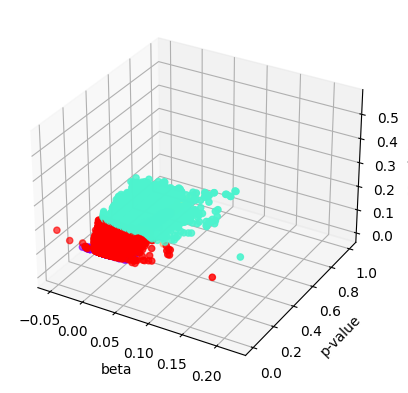

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

event = pd.read_csv('event.csv', index_col = 0)
features = event[['beta', 'pvalue', 'corr']]
kmeans = KMeans(n_clusters=6)
kmeans.fit(features)
event['kmean_cluster'] = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(event['beta'], event['pvalue'], event['corr'], c=event['kmean_cluster'], cmap='rainbow')
ax.set_xlabel('beta')
ax.set_ylabel('p-value')
ax.set_zlabel('correlation')


### 분포 자체는 Z축인 corr 도 영향이 있으나 그래프 상으로는 corr가 매우 크지 않은 탓에 
### 주로 p-value 가 낮은 집단과 높은 집단으로 구분되는 것 처럼 보임

In [6]:
b = event.copy()
    
for i in range(0,6):
    b.loc[b['kmean_cluster'] == i, 'class_kmean'] = int(b[b['kmean_cluster'] == i]['pvalue'].mean() < 0.1) #각 클러스터별로 보고 있으니, 그 pvalue 만 봐서 평균이 0.1 보다 작은가

### p-value가 낮은 경우 코인이 동화 된 것으로 추정가능하다면
### 코인시장이 주식시장과 비슷하게 움직이는 기간과, 아닌 기간이 존재하기에,
### 각 사건별로, 이전 250일간 주식시장과 연관이 있는 경우 그 사건 당시, 이후 잠깐동안
### 코인시장에 동화된 것으로 간주하고자 한다

In [9]:
print('p_value 낮은, 즉 동화 추정 코인 수 : ',b['class_kmean'].sum())
print('전체 코인 수 : ', len(b))
print('동화 율 : ', b['class_kmean'].sum()/len(b))

p_value 낮은, 즉 동화 추정 코인 수 :  10235.0
전체 코인 수 :  15586
동화 율 :  0.656679070961119


In [18]:
knn1 = b[b['class_kmean'] == 1].copy().reset_index(drop=True) #knn 상 동화 추정
knn2 = b[b['class_kmean'] == 0].copy().reset_index(drop=True) #knn 상 동화 아닌걸로 추정

knn1.to_csv('event_knn1.csv', index = True)
knn2.to_csv('event_knn2.csv', index = True)

### 두 집단, p-value로 구분하여 동화 추정된 knn1 집단과 knn2집단에 대해서 event study를 진행해 보고자 함
### 이때 시장베타는, 주식시장에 동화되었을 경우 S&P500이 맞다고 볼 수 있으나,
### 기본적으로 event study는 대표성을 띄는 지수를 시장베타로 추정해야되기에
### event 내에서 BTC (비트코인) 을 제외하고 BTC를 통하여 추정하는 방식으로도 진행을 해 보고자 한다.

#
#
# -Event study 통한 행태 분석-

# 1. S&P 500과의 추정

In [11]:
close_df = pd.read_csv('close_df_cc.csv', index_col=0)
df = pd.read_csv('df.csv', index_col=0)
beta = pd.read_csv('beta.csv', index_col=0)
alpha = pd.read_csv('alpha.csv', index_col=0)
knn1=pd.to_csv('event_knn1.csv', index_col=0)
knn2=pd.to_csv('event_knn2.csv', index_col=0)

#knn1 기준
A = pd.DataFrame()
import statistics
for k in range(0, len(knn1)):
    date1 = knn1.loc[k,'date']
    name1 = knn1.loc[k, 'name']

    m = df.index.get_loc(date1)
    n = df.columns.get_loc(name1)
    if (len(df.iloc[m-5:m+11, n])==16):
        A.loc[k, 'name'] = name1
        A.loc[k, 'day'] = date1
        A.loc[k, 'diff'] = df.iloc[m,n]
        A.loc[k, 'std'] = statistics.stdev(df.iloc[m-250:m, n])
        A.loc[k, 'sp500'] = df.iloc[m, len(df.columns)-2]
        A.loc[k, '52_WK_HI'] = close_df.iloc[m-1,n]/max(close_df.iloc[m-250:m, n])
        A.loc[k, '52_WK_LO'] = min(close_df.iloc[m-250:m,n])/close_df.iloc[m-1,n]
        aalpha = alpha.iloc[m,n]
        bbeta = beta.iloc[m, n]
        C = 1+(df.iloc[m-5:m+11, n] - (aalpha + bbeta*df.iloc[m-5:m+11, len(df.columns)-2]))
        A.loc[k, "CAR(-5,-1)"]=(C[0])*(C[1])*(C[2])*(C[3])*(C[4])-1
        if(A.loc[k, "CAR(-5,-1)"]<0):
                A.loc[k, "CONTRADICTION"]=1
        else:
                A.loc[k, "CONTRADICTION"]=0

        A.loc[k, "Day1"] = C[6]-1
        A.loc[k, "Day2"] = C[7]-1
        ppp=1
        for pp in range(6, 11):
            ppp = ppp*(C[pp])
        A.loc[k, "Day5"] = ppp-1
        ppp=1
        for pp in range(6, 16):
            ppp = ppp*(C[pp])
        A.loc[k, "Day10"] = ppp-1
    
    
#knn2 기준
B = pd.DataFrame()
import statistics
for k in range(0, len(knn2)):
    date1 = knn2.loc[k,'date']
    name1 = knn2.loc[k, 'name']

    m = df.index.get_loc(date1)
    n = df.columns.get_loc(name1)
    if (len(df.iloc[m-5:m+11, n])==16):
        B.loc[k, 'name'] = name1
        B.loc[k, 'day'] = date1
        B.loc[k, 'diff'] = df.iloc[m,n]
        B.loc[k, 'std'] = statistics.stdev(df.iloc[m-250:m, n])
        B.loc[k, 'sp500'] = df.iloc[m, len(df.columns)-2]
        B.loc[k, '52_WK_HI'] = close_df.iloc[m-1,n]/max(close_df.iloc[m-250:m, n])
        B.loc[k, '52_WK_LO'] = min(close_df.iloc[m-250:m,n])/close_df.iloc[m-1,n]
        aalpha = alpha.iloc[m,n]
        bbeta = beta.iloc[m, n]
        C = 1+(df.iloc[m-5:m+11, n] - (aalpha + bbeta*df.iloc[m-5:m+11, len(df.columns)-2]))
        B.loc[k, "CAR(-5,-1)"]=(C[0])*(C[1])*(C[2])*(C[3])*(C[4])-1
        if(B.loc[k, "CAR(-5,-1)"]<0):
                B.loc[k, "CONTRADICTION"]=1
        else:
                B.loc[k, "CONTRADICTION"]=0

        B.loc[k, "Day1"] = C[6]-1
        B.loc[k, "Day2"] = C[7]-1
        ppp=1
        for pp in range(6, 11):
            ppp = ppp*(C[pp])
        B.loc[k, "Day5"] = ppp-1
        ppp=1
        for pp in range(6, 16):
            ppp = ppp*(C[pp])
        B.loc[k, "Day10"] = ppp-1
    

A = A.dropna().reset_index(drop=True)
A.to_csv('Proxy_knn1.csv', index = True) #knn으로 분류한, p-value 낮아서 동화 된 것으로 추정 
B = B.dropna().reset_index(drop=True)
B.to_csv('Proxy_knn2.csv', index = True) #knn으로 분류한, p-value 높아서 동화 안된 것으로 추정 


In [12]:
def star(a):
    if a < 0.01:
        z = '***'
    elif a >=0.01 and a < 0.05:
        z = '**'
    elif a >=0.05 and a < 0.1:
        z = '*'
    else:
        z = ' '
    return z

### Proxy_knn1 : kmean 기준, 동화된 것으로 추정됨

In [90]:
import scipy.stats as stats
q=['1', '2', '5', '10']
A = pd.read_csv('Proxy_knn1.csv', index_col=0)
UP_A = A[A['diff']>0].reset_index(drop=True)
UP_A1 = UP_A[UP_A['52_WK_HI']>=0.7].reset_index(drop=True)
UP_A2 = UP_A[UP_A['52_WK_LO']>=0.7].reset_index(drop=True)
DOWN_A = A[A['diff']<0].reset_index(drop=True)
DOWN_A1 = DOWN_A[DOWN_A['52_WK_HI']>=0.7].reset_index(drop=True)
DOWN_A2 = DOWN_A[DOWN_A['52_WK_LO']>=0.7].reset_index(drop=True)

result_A_all = pd.DataFrame()
result_A_all['SR>10%('+str(len(UP_A))+')']=0
result_A_all['SR>10%(HI>0.7)('+str(len(UP_A1))+')']=0
result_A_all['SR>10%(LO>0.7)('+str(len(UP_A2))+')']=0
result_A_all['SR<-10%('+str(len(DOWN_A))+')']=0
result_A_all['SR<-10%(HI>0.7)('+str(len(DOWN_A1))+')']=0
result_A_all['SR<-10%(LO>0.7)('+str(len(DOWN_A2))+')']=0
for i in range(0, 4):
    result_A_all.loc["Day"+q[i]]=[star(stats.ttest_1samp(a=UP_A['Day'+q[i]], popmean=0).pvalue)+str(round(100*UP_A['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_A['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=UP_A1['Day'+q[i]], popmean=0).pvalue)+str(round(100*UP_A1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_A1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=UP_A2['Day'+q[i]], popmean=0).pvalue)+str(round(100*UP_A2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_A2['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=DOWN_A['Day'+q[i]], popmean=0).pvalue)+str(round(100*DOWN_A['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_A['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=DOWN_A1['Day'+q[i]], popmean=0).pvalue)+str(round(100*DOWN_A1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_A1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=DOWN_A2['Day'+q[i]], popmean=0).pvalue)+str(round(100*DOWN_A2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_A2['Day'+q[i]], popmean=0).pvalue,2))+'%)']
    
result_A_all.to_csv('knn1_result.csv', index=True)
print(result_A_all)

          SR>10%(5058) SR>10%(HI>0.7)(1701) SR>10%(LO>0.7)(1229)  \
Day1    ***-0.85(0.0%)        -0.19(50.72%)       ***-1.76(0.0%)   
Day2      0.04(76.06%)         *0.48(5.85%)         -0.3(17.47%)   
Day5   ***-0.84(0.44%)        ***2.0(0.06%)       ***-3.51(0.0%)   
Day10     0.08(83.37%)        ***4.52(0.0%)       ***-4.48(0.0%)   

       SR<-10%(5155) SR<-10%(HI>0.7)(1326) SR<-10%(LO>0.7)(1554)  
Day1   ***1.25(0.0%)         ***2.08(0.0%)          0.57(13.77%)  
Day2   **-0.42(2.9%)         -0.19(51.78%)        ***-1.63(0.0%)  
Day5    0.28(64.52%)         **1.07(4.17%)         -0.76(14.85%)  
Day10   0.06(87.72%)          0.01(98.65%)       ***-1.28(0.74%)  


### Proxy_knn2 : kmean 기준, 동화안된 것으로 추정됨

In [89]:
q = ['1', '2', '5', '10']
B = pd.read_csv('Proxy_knn2.csv', index_col=0)
UP_B = B[B['diff'] > 0].reset_index(drop=True)
UP_B1 = UP_B[UP_B['52_WK_HI'] >= 0.7].reset_index(drop=True)
UP_B2 = UP_B[UP_B['52_WK_LO'] >= 0.7].reset_index(drop=True)
DOWN_B = B[B['diff'] < 0].reset_index(drop=True)
DOWN_B1 = DOWN_B[DOWN_B['52_WK_HI'] >= 0.7].reset_index(drop=True)
DOWN_B2 = DOWN_B[DOWN_B['52_WK_LO'] >= 0.7].reset_index(drop=True)

result_B_all = pd.DataFrame()
result_B_all['SR>10%('+str(len(UP_B))+')'] = 0
result_B_all['SR>10%(HI>0.7)('+str(len(UP_B1))+')'] = 0
result_B_all['SR>10%(LO>0.7)('+str(len(UP_B2))+')'] = 0
result_B_all['SR<-10%('+str(len(DOWN_B))+')'] = 0
result_B_all['SR<-10%(HI>0.7)('+str(len(DOWN_B1))+')'] = 0
result_B_all['SR<-10%(LO>0.7)('+str(len(DOWN_B2))+')'] = 0

for i in range(0, 4):
    result_B_all.loc["Day"+q[i]] = [
        star(stats.ttest_1samp(a=UP_B['Day'+q[i]], popmean=0).pvalue) + str(round(100*UP_B['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_B['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=UP_B1['Day'+q[i]], popmean=0).pvalue) + str(round(100*UP_B1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_B1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=UP_B2['Day'+q[i]], popmean=0).pvalue) + str(round(100*UP_B2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_B2['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=DOWN_B['Day'+q[i]], popmean=0).pvalue) + str(round(100*DOWN_B['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_B['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=DOWN_B1['Day'+q[i]], popmean=0).pvalue) + str(round(100*DOWN_B1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_B1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=DOWN_B2['Day'+q[i]], popmean=0).pvalue) + str(round(100*DOWN_B2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_B2['Day'+q[i]], popmean=0).pvalue,2))+'%)'
    ]

result_B_all.to_csv('knn2_result.csv', index=True)
print(result_B_all)


          SR>10%(2773) SR>10%(HI>0.7)(948) SR>10%(LO>0.7)(565)  \
Day1   ***-1.14(0.09%)        *1.04(8.93%)     ***-3.37(0.01%)   
Day2       0.11(70.9%)        0.53(19.96%)        0.19(70.97%)   
Day5     -0.68(48.26%)       ***5.43(0.0%)      **-3.07(1.26%)   
Day10    -1.46(33.52%)       ***8.98(0.0%)     ***-4.13(0.55%)   

        SR<-10%(2526) SR<-10%(HI>0.7)(722) SR<-10%(LO>0.7)(600)  
Day1    ***2.41(0.0%)        ***2.95(0.0%)         1.16(21.84%)  
Day2     0.41(10.91%)         -0.01(97.4%)        -0.14(81.81%)  
Day5    -2.37(64.79%)         0.99(24.04%)      ***-4.81(0.01%)  
Day10    9.16(59.99%)        **2.59(3.75%)      ***-6.84(0.02%)  


## 상한가 근처 상승 -> 양의 이상수익률,
## 기회를 놓치지 않기 위해서 매수 증가, 공포감 -> 과민반응

## 하한가 근처 하락 -> 음의 이상수익률
## 없어질지 모른다는(상장폐지), 공포감 -> 과민반응

## 하한가 근처 상승 -> 음의 이상수익률
## 하한가라는 공포감이 지배, day1 등에서 최대한 과하게 반응을 안하려함, 상승하였음에도 이후 예상보다 수익률이 낮음

## 상한가 근처 하락 -> 유의성 적은 양의 이상수익률, 더 이상 떨어지지는 않을 것이다? 약간 애매함

### 허나, knn1, knn2 집단 간, 즉 K-mean clustering 기준으로 두 집단을 나누었을때
### 유의한 차이를 발견못함
### 오히려 scale의 차이로 보아, 주식시장에 영향을 받지않는, 즉 K-mean clustering 기준으로
### 주식시장 동화 안된 집단의 경우 scale이 더 큰 것으로 보임, 허나, 시장 베타는 S&P 500의 영향을 받을 수도 있음 -> 뚜렷한 지표?

# 2. BTC 와의 추정

In [107]:
close_df = pd.read_csv('close_df_cc.csv', index_col=0)
df = pd.read_csv('df.csv', index_col=0)
beta = pd.read_csv('beta.csv', index_col=0)
alpha = pd.read_csv('alpha.csv', index_col=0)
knn1=pd.read_csv('event_knn1.csv', index_col=0)
knn2=pd.read_csv('event_knn2.csv', index_col=0)

#이벤트 내역에서 btc를 제거해줌
knn1 = knn1[knn1['name']!='btc'].reset_index(drop=True)
knn2 = knn2[knn2['name']!='btc'].reset_index(drop=True)

#시장지수가 되는 btc
btc = pd.DataFrame(df['btc'].copy())

#knn1 기준
A = pd.DataFrame()
import statistics
from statsmodels.regression.rolling import RollingOLS
for k in range(0, len(knn1)):
    date1 = knn1.loc[k,'date']
    name1 = knn1.loc[k, 'name']

    m = df.index.get_loc(date1)
    n = df.columns.get_loc(name1)
    if (len(df.iloc[m-5:m+11, n])==16):
        A.loc[k, 'name'] = name1
        A.loc[k, 'day'] = date1
        A.loc[k, 'diff'] = df.iloc[m,n]
        A.loc[k, 'std'] = statistics.stdev(df.iloc[m-250:m, n])
        A.loc[k, 'sp500'] = df.iloc[m, len(df.columns)-2]
        A.loc[k, '52_WK_HI'] = close_df.iloc[m-1,n]/max(close_df.iloc[m-250:m, n])
        A.loc[k, '52_WK_LO'] = min(close_df.iloc[m-250:m,n])/close_df.iloc[m-1,n]
        
        #diff와 BTC 간에 capm으로 추정함
        B1=pd.DataFrame()
        B1.index.names = ['Date']
        B1["diff"]=df.iloc[m-250:m+11,n]
        B1["BTC"]=btc.iloc[m-250:m+11,0]                
        roll_reg2 = RollingOLS.from_formula('diff ~ BTC', window=251,min_nobs=251, data=B1,missing='drop') #capm모델용 무위험이자율 하기 다요인용3
        model3 = roll_reg2.fit()
        para2 = model3.params
        a=para2.iloc[250,0]
        b=para2.iloc[250,1]
        C=1+(B1.iloc[245:262,0]-(a+b*B1.iloc[245:262,1]))
        
        
        A.loc[k, "CAR(-5,-1)"]=(C[0])*(C[1])*(C[2])*(C[3])*(C[4])-1
        if(A.loc[k, "CAR(-5,-1)"]<0):
                A.loc[k, "CONTRADICTION"]=1
        else:
                A.loc[k, "CONTRADICTION"]=0

        A.loc[k, "Day1"] = C[6]-1
        A.loc[k, "Day2"] = C[7]-1
        ppp=1
        for pp in range(6, 11):
            ppp = ppp*(C[pp])
        A.loc[k, "Day5"] = ppp-1
        ppp=1
        for pp in range(6, 16):
            ppp = ppp*(C[pp])
        A.loc[k, "Day10"] = ppp-1
    
    
#knn2 기준
B = pd.DataFrame()
import statistics
for k in range(0, len(knn2)):
    date1 = knn2.loc[k,'date']
    name1 = knn2.loc[k, 'name']

    m = df.index.get_loc(date1)
    n = df.columns.get_loc(name1)
    if (len(df.iloc[m-5:m+11, n])==16):
        B.loc[k, 'name'] = name1
        B.loc[k, 'day'] = date1
        B.loc[k, 'diff'] = df.iloc[m,n]
        B.loc[k, 'std'] = statistics.stdev(df.iloc[m-250:m, n])
        B.loc[k, 'sp500'] = df.iloc[m, len(df.columns)-2]
        B.loc[k, '52_WK_HI'] = close_df.iloc[m-1,n]/max(close_df.iloc[m-250:m, n])
        B.loc[k, '52_WK_LO'] = min(close_df.iloc[m-250:m,n])/close_df.iloc[m-1,n]
        
        #diff와 BTC 간에 capm으로 추정함
        B1=pd.DataFrame()
        B1.index.names = ['Date']
        B1["diff"]=df.iloc[m-250:m+11,n]
        B1["BTC"]=btc.iloc[m-250:m+11,0]                
        roll_reg2 = RollingOLS.from_formula('diff ~ BTC', window=251,min_nobs=251, data=B1,missing='drop') #capm모델용 무위험이자율 하기 다요인용3
        model3 = roll_reg2.fit()
        para2 = model3.params
        a=para2.iloc[250,0]
        b=para2.iloc[250,1]
        C=1+(B1.iloc[245:262,0]-(a+b*B1.iloc[245:262,1]))
        
        B.loc[k, "CAR(-5,-1)"]=(C[0])*(C[1])*(C[2])*(C[3])*(C[4])-1
        if(B.loc[k, "CAR(-5,-1)"]<0):
                B.loc[k, "CONTRADICTION"]=1
        else:
                B.loc[k, "CONTRADICTION"]=0

        B.loc[k, "Day1"] = C[6]-1
        B.loc[k, "Day2"] = C[7]-1
        ppp=1
        for pp in range(6, 11):
            ppp = ppp*(C[pp])
        B.loc[k, "Day5"] = ppp-1
        ppp=1
        for pp in range(6, 16):
            ppp = ppp*(C[pp])
        B.loc[k, "Day10"] = ppp-1
    

A = A.dropna().reset_index(drop=True)
A.to_csv('Proxy_knn1_btc.csv', index = True) #knn으로 분류한, p-value 낮아서 동화 된 것으로 추정 
B = B.dropna().reset_index(drop=True)
B.to_csv('Proxy_knn2_btc.csv', index = True) #knn으로 분류한, p-value 높아서 동화 안된 것으로 추정 


### Proxy_knn1 : kmean 기준, 동화된 것으로 추정됨

In [108]:
import scipy.stats as stats
q=['1', '2', '5', '10']
A = pd.read_csv('Proxy_knn1_btc.csv', index_col=0)
UP_A = A[A['diff']>0].reset_index(drop=True)
UP_A1 = UP_A[UP_A['52_WK_HI']>=0.7].reset_index(drop=True)
UP_A2 = UP_A[UP_A['52_WK_LO']>=0.7].reset_index(drop=True)
DOWN_A = A[A['diff']<0].reset_index(drop=True)
DOWN_A1 = DOWN_A[DOWN_A['52_WK_HI']>=0.7].reset_index(drop=True)
DOWN_A2 = DOWN_A[DOWN_A['52_WK_LO']>=0.7].reset_index(drop=True)

result_A_all = pd.DataFrame()
result_A_all['SR>10%('+str(len(UP_A))+')']=0
result_A_all['SR>10%(HI>0.7)('+str(len(UP_A1))+')']=0
result_A_all['SR>10%(LO>0.7)('+str(len(UP_A2))+')']=0
result_A_all['SR<-10%('+str(len(DOWN_A))+')']=0
result_A_all['SR<-10%(HI>0.7)('+str(len(DOWN_A1))+')']=0
result_A_all['SR<-10%(LO>0.7)('+str(len(DOWN_A2))+')']=0
for i in range(0, 4):
    result_A_all.loc["Day"+q[i]]=[star(stats.ttest_1samp(a=UP_A['Day'+q[i]], popmean=0).pvalue)+str(round(100*UP_A['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_A['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=UP_A1['Day'+q[i]], popmean=0).pvalue)+str(round(100*UP_A1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_A1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=UP_A2['Day'+q[i]], popmean=0).pvalue)+str(round(100*UP_A2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_A2['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=DOWN_A['Day'+q[i]], popmean=0).pvalue)+str(round(100*DOWN_A['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_A['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=DOWN_A1['Day'+q[i]], popmean=0).pvalue)+str(round(100*DOWN_A1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_A1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
                        star(stats.ttest_1samp(a=DOWN_A2['Day'+q[i]], popmean=0).pvalue)+str(round(100*DOWN_A2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_A2['Day'+q[i]], popmean=0).pvalue,2))+'%)']
    
result_A_all.to_csv('knn1_result_btc.csv', index=True)
print(result_A_all)

          SR>10%(5043) SR>10%(HI>0.7)(1698) SR>10%(LO>0.7)(1222)  \
Day1     ***-0.6(0.0%)         -0.1(70.03%)        ***-1.1(0.0%)   
Day2      -0.12(30.0%)         0.08(74.15%)         -0.21(26.0%)   
Day5   ***-0.88(0.11%)         0.56(30.11%)       **-0.99(1.32%)   
Day10  ***-1.19(0.08%)        **1.59(4.19%)        *-0.89(7.07%)   

       SR<-10%(5136) SR<-10%(HI>0.7)(1321) SR<-10%(LO>0.7)(1545)  
Day1   ***0.64(0.0%)         ***1.19(0.0%)          0.54(11.79%)  
Day2   *-0.33(5.37%)         -0.03(88.64%)          -0.39(23.6%)  
Day5    0.54(28.46%)          0.37(40.27%)         ***1.97(0.0%)  
Day10    0.12(71.1%)        **-1.61(1.91%)         ***2.34(0.0%)  


### Proxy_knn2 : kmean 기준, 동화안된 것으로 추정됨

In [109]:
q = ['1', '2', '5', '10']
B = pd.read_csv('Proxy_knn2_btc.csv', index_col=0)
UP_B = B[B['diff'] > 0].reset_index(drop=True)
UP_B1 = UP_B[UP_B['52_WK_HI'] >= 0.7].reset_index(drop=True)
UP_B2 = UP_B[UP_B['52_WK_LO'] >= 0.7].reset_index(drop=True)
DOWN_B = B[B['diff'] < 0].reset_index(drop=True)
DOWN_B1 = DOWN_B[DOWN_B['52_WK_HI'] >= 0.7].reset_index(drop=True)
DOWN_B2 = DOWN_B[DOWN_B['52_WK_LO'] >= 0.7].reset_index(drop=True)

result_B_all = pd.DataFrame()
result_B_all['SR>10%('+str(len(UP_B))+')'] = 0
result_B_all['SR>10%(HI>0.7)('+str(len(UP_B1))+')'] = 0
result_B_all['SR>10%(LO>0.7)('+str(len(UP_B2))+')'] = 0
result_B_all['SR<-10%('+str(len(DOWN_B))+')'] = 0
result_B_all['SR<-10%(HI>0.7)('+str(len(DOWN_B1))+')'] = 0
result_B_all['SR<-10%(LO>0.7)('+str(len(DOWN_B2))+')'] = 0

for i in range(0, 4):
    result_B_all.loc["Day"+q[i]] = [
        star(stats.ttest_1samp(a=UP_B['Day'+q[i]], popmean=0).pvalue) + str(round(100*UP_B['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_B['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=UP_B1['Day'+q[i]], popmean=0).pvalue) + str(round(100*UP_B1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_B1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=UP_B2['Day'+q[i]], popmean=0).pvalue) + str(round(100*UP_B2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=UP_B2['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=DOWN_B['Day'+q[i]], popmean=0).pvalue) + str(round(100*DOWN_B['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_B['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=DOWN_B1['Day'+q[i]], popmean=0).pvalue) + str(round(100*DOWN_B1['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_B1['Day'+q[i]], popmean=0).pvalue,2))+'%)',
        star(stats.ttest_1samp(a=DOWN_B2['Day'+q[i]], popmean=0).pvalue) + str(round(100*DOWN_B2['Day'+q[i]].mean(),2))+'('+str(round(100*stats.ttest_1samp(a=DOWN_B2['Day'+q[i]], popmean=0).pvalue,2))+'%)'
    ]

result_B_all.to_csv('knn2_result_btc.csv', index=True)
print(result_B_all)


          SR>10%(2748) SR>10%(HI>0.7)(929) SR>10%(LO>0.7)(562)  \
Day1   ***-1.04(0.25%)         0.76(21.4%)      ***-2.8(0.13%)   
Day2     -0.03(91.87%)         0.1(80.23%)        0.51(29.65%)   
Day5     -1.35(13.39%)      ***2.92(0.66%)       -0.33(78.38%)   
Day10    *-2.39(5.67%)       ***3.89(1.0%)        1.22(40.65%)   

        SR<-10%(2500) SR<-10%(HI>0.7)(704) SR<-10%(LO>0.7)(597)  
Day1    ***1.91(0.0%)        ***1.74(0.0%)          1.5(10.02%)  
Day2   ***0.85(0.03%)         0.12(71.92%)       ***1.53(0.51%)  
Day5    -0.74(88.51%)         -0.2(76.81%)         0.67(56.52%)  
Day10    8.96(54.28%)         -0.73(48.2%)         2.02(29.79%)  


### 이전보다유의한 결과가 안 나오는 이유는, event 에 대해 
### 1. S&P500이 코인 시장 투자자들에게 더 많은 관심을 주는 지수 일 수 있다.
### 2. 비트코인 자체가 변동성이 매우 높기 때문에 대표 시장 지수가 될 수 없다.
### 3. 비트코인 자체는 코인 시장의 일부이기에, 코인 시장내 특정 요인의 영향을 받을 수 있으며
### S&P 500은 다양한 산업을 아우르는 광범위한 지수이기에 영향을 미치는 다양한 경제적 요인을 포착 가능할 수 있다.

### 4. Knn1만의 결과만 보면 동화된 코인의 경우 하한가 근처 하락의 경우 유의한 양의 이상수익률
### -> 이는 기존의 공포가 아닌 탐욕 지수가 높게 발동한 것으로 볼 수도 있음, 혹은 동화된 코인들만 어떠한 행태적 변화를 보인다.
### 등의 요인이 영향을 끼칠 수 있다.

### 그렇기에 Yukun Liu 의 논문과 유사하게 crypto 시장 내 지수 등을 사용해야 할 가능성을 시사한다.

#
#
# -예측-

### CAR이 유의성을 보이는 S&P500을 시장지수로 보았을 때 CAR 10 기준
### 상한가 근처 상승이벤트 시 AR 양수 추출
### 하한가 근처 이벤트 시 AR 음수 추출
### 이들을 alpha, beta, 상한가 근처, 하한가 근처 값 기준으로 학습을 시켜보도록 하자
### 만일 예측이 가능하다면, 이전 250일간의 S&P500과의 관계, 상한가,하한가 근처 여부 등으로
### 이후 어떠한 식으로 변화할 지에 대해서 투자자들이 예측이 가능 할 것 이다.

In [94]:
A = pd.read_csv('Proxy_knn1.csv', index_col=0)
B = pd.read_csv('Proxy_knn2.csv', index_col=0)

filtered_A1 = A[(A['diff'] > 0) & (A['52_WK_HI'] >= 0.7) & (A['Day10'] > 0)]
result1 = filtered_A1[['name', 'day']]
filtered_A2 = A[(A['52_WK_LO'] >= 0.7) & (A['Day10'] < 0)]
result2 = filtered_A2[['name', 'day']]

filtered_B1 = B[(B['diff'] > 0) & (B['52_WK_HI'] >= 0.7) & (B['Day10'] > 0)]
result3 = filtered_B1[['name', 'day']]
filtered_B2 = B[(B['52_WK_LO'] >= 0.7) & (B['Day10'] < 0)]
result4 = filtered_B2[['name', 'day']]

result = pd.concat([result1, result2, result3, result4], ignore_index=True) # 필요한 name 과 day 생성

In [95]:
event=pd.read_csv('event.csv', index_col = 0)
event_map = result.set_index(['name', 'day']).index #name과 day들을 추출
event['fear'] = event.apply(lambda x: 1 if (x['name'], x['date']) in event_map else 0, axis=1)
#fear 들이 공포감에 반응하는것으로 추축되는 result로 추출한 name과 date 와 일치하는 친구들

### 머신러닝 위한 스필릿 및 스케일링

In [96]:
from sklearn.model_selection import train_test_split
#split
X = event[['df', 'alpha', 'beta', '52_WK_HI', '52_WK_LO']]
y = event['fear']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler
#스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1. Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier
#랜덤포레스트로 학습
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_scaled, y_train)

#예측
from sklearn.metrics import accuracy_score, classification_report
y_pred_clf = clf.predict(X_test_scaled)
print(f"랜덤포레스트 Accuracy: {accuracy_score(y_test, y_pred_clf)}")
ac_clf = accuracy_score(y_test, y_pred_clf)
print(classification_report(y_test, y_pred_clf))

랜덤포레스트 Accuracy: 0.8389993585631815
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2412
           1       0.64      0.67      0.65       706

    accuracy                           0.84      3118
   macro avg       0.77      0.78      0.77      3118
weighted avg       0.84      0.84      0.84      3118



### 2. Support Vector Machines

In [98]:
#svm 활용
from sklearn.svm import SVC
#모델 초기화
svm_clf = SVC(kernel='linear', probability=True, random_state=0)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)

#예측
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")
ac_svm = accuracy_score(y_test, y_pred_svm)
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7735728030788968
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2412
           1       0.00      0.00      0.00       706

    accuracy                           0.77      3118
   macro avg       0.39      0.50      0.44      3118
weighted avg       0.60      0.77      0.67      3118



C:\Users\siro8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siro8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siro8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### 3. Gradient Boosting

In [99]:
#그래디언트 활용
from sklearn.ensemble import GradientBoostingClassifier
#모델 초기화
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
gb_clf.fit(X_train_scaled, y_train)
y_pred_gb = gb_clf.predict(X_test_scaled)

#예측
print(f"그래디언트 Accuracy: {accuracy_score(y_test, y_pred_gb)}")
ac_gb = accuracy_score(y_test, y_pred_gb)
print(classification_report(y_test, y_pred_gb))

그래디언트 Accuracy: 0.8329057087876844
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2412
           1       0.62      0.66      0.64       706

    accuracy                           0.83      3118
   macro avg       0.76      0.77      0.77      3118
weighted avg       0.84      0.83      0.83      3118



### 4. DecisionTree

In [100]:
#디시전트리 튜닝
from sklearn.tree import DecisionTreeClassifier
#모델 초기화
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

#예측
print(f"디시전트리 Accuracy: {accuracy_score(y_test, y_pred_dtc)}")
ac_dtc = accuracy_score(y_test, y_pred_dtc)
print(classification_report(y_test, y_pred_dtc))

디시전트리 Accuracy: 0.8155869146889031
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2412
           1       0.60      0.58      0.59       706

    accuracy                           0.82      3118
   macro avg       0.74      0.73      0.73      3118
weighted avg       0.81      0.82      0.81      3118



In [101]:
#ac_clf : r.f, ac_svm : svm, ac_gb : gb, ac_dtc : dtc
#뭐가 가장 좋았는지 딕셔너리로 결합 후 출력해봄
acc= {'Random Forest': ac_clf, 'SVM': ac_svm, 'Gradient Boosting': ac_gb, 'Decision Tree': ac_dtc}
best_name = max(acc, key=acc.get)

print(f"best is : {best_name}")

best is : Random Forest


# 튜닝 - Grid Search

# 1. Random Forest

In [102]:
from sklearn.model_selection import GridSearchCV
#그리드 서치 이용할 예정

#랜덤포레스트 활용
# 랜덤 포레스트 분류기 초기화 - 독립, 교차 검증 등을 위해서 초기화 해줘야됨
clf = RandomForestClassifier(random_state=0)

n_estimators=[64,100,128,200]
max_features= [2,3,4]
bootstrap = [True]
oob_score = [True,False]

#하이퍼파라미터
param_grid = {
    'n_estimators':n_estimators,
     'max_features':max_features,
     'bootstrap':bootstrap
}

clf_grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,)
clf_grid_search.fit(X_train_scaled, y_train)


#그리드 서치로 찾은걸로 예측
best_clf = clf_grid_search.best_estimator_
y_pred_clf1 = best_clf.predict(X_test_scaled)

print(f"랜덤포레스트 Accuracy with best parameters: {accuracy_score(y_test, y_pred_clf1)}")
ac_clf1 = accuracy_score(y_test, y_pred_clf1)
print(classification_report(y_test, y_pred_clf1))

랜덤포레스트 Accuracy with best parameters: 0.8386786401539449
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2412
           1       0.64      0.67      0.65       706

    accuracy                           0.84      3118
   macro avg       0.77      0.78      0.77      3118
weighted avg       0.84      0.84      0.84      3118



# 2. Support Vector Machine

In [103]:
#svm 활용
from sklearn.model_selection import GridSearchCV
#파라미터
svm_param_grid = {'C':[0.01,0.1,1],'kernel':['linear','rbf']}
svm_grid_search = GridSearchCV(svm_clf, svm_param_grid,)
svm_grid_search.fit(X_train_scaled, y_train)

best_svm = svm_grid_search.best_estimator_
y_pred_svm1 = best_svm.predict(X_test_scaled)

print(f"SVM Accuracy with best parameters: {accuracy_score(y_test, y_pred_svm1)}")
ac_svm1 = accuracy_score(y_test, y_pred_svm1)
print(classification_report(y_test, y_pred_svm1))

SVM Accuracy with best parameters: 0.8159076330981399
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2412
           1       0.60      0.58      0.59       706

    accuracy                           0.82      3118
   macro avg       0.74      0.73      0.73      3118
weighted avg       0.81      0.82      0.82      3118



# 3. Gradient Boosting

In [104]:
#gb 활용

#파라미터
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5]
}

gb_grid_search = GridSearchCV(gb_clf, gb_param_grid,)
gb_grid_search.fit(X_train_scaled, y_train)

best_gb = gb_grid_search.best_estimator_
y_pred_gb1 = best_gb.predict(X_test_scaled)

print(f"GM Accuracy with best parameters: {accuracy_score(y_test, y_pred_gb1)}")
ac_gb1 = accuracy_score(y_test, y_pred_gb1)
print(classification_report(y_test, y_pred_gb1))

GM Accuracy with best parameters: 0.8306606799230276
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2412
           1       0.62      0.66      0.64       706

    accuracy                           0.83      3118
   macro avg       0.76      0.77      0.76      3118
weighted avg       0.84      0.83      0.83      3118



# 4. Decision Tree

In [105]:
#DT 활용

param_grid_dtc = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

grid_search_dtc = GridSearchCV(dtc, param_grid_dtc,)
grid_search_dtc.fit(X_train_scaled, y_train)

best_dtc = grid_search_dtc.best_estimator_
y_pred_dtc1 = best_dtc.predict(X_test_scaled)

print(f"디시전트리 Accuracy with best parameters: {accuracy_score(y_test, y_pred_dtc1)}")
ac_dtc1 = accuracy_score(y_test, y_pred_dtc1)
print(classification_report(y_test, y_pred_dtc1))

디시전트리 Accuracy with best parameters: 0.8290570878768442
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2412
           1       0.63      0.60      0.62       706

    accuracy                           0.83      3118
   macro avg       0.76      0.75      0.75      3118
weighted avg       0.83      0.83      0.83      3118



In [106]:
#ac_clf1 : r.f, ac_svm1 : svm, ac_gb1 : gb, ac_dtc1 : dtc
#뭐가 가장 좋았는지 딕셔너리로 결합 후 출력해봄
acc1= {'Random Forest': ac_clf1, 'SVM': ac_svm1, 'Gradient Boosting': ac_gb1, 'Decision Tree': ac_dtc1}
best_name1 = max(acc1, key=acc1.get)

print(f"best is : {best_name1}")

best is : Random Forest
